In [2]:
import pixiedust
pixiedust.installPackage("https://github.com/ibm-cds-labs/spark.samples/raw/master/dist/streaming-twitter-assembly-1.6.jar")

Pixiedust database opened successfully
Package already installed: https://github.com/ibm-cds-labs/spark.samples/raw/master/dist/streaming-twitter-assembly-1.6.jar


/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/Users/dtaieb/anac

In [3]:
%%scala
val demo = com.ibm.cds.spark.samples.StreamingTwitter
demo.setConfig("twitter4j.oauth.consumerKey","XXXX")
demo.setConfig("twitter4j.oauth.consumerSecret","XXXX")
demo.setConfig("twitter4j.oauth.accessToken","XXXX")
demo.setConfig("twitter4j.oauth.accessTokenSecret","XXXX")
demo.setConfig("watson.tone.url","https://gateway.watsonplatform.net/tone-analyzer/api")
demo.setConfig("watson.tone.password","XXXX")
demo.setConfig("watson.tone.username","XXXX")

import org.apache.spark.streaming._
demo.startTwitterStreaming(sc, Seconds(10))

Twitter stream started
Tweets are collected real-time and analyzed
To stop the streaming and start interacting with the data use: StreamingTwitter.stopTwitterStreaming
Receiver Started: TwitterReceiver-0
Batch started with 0 records
Batch completed with 0 records
Batch started with 167 records
Received directive to stop twitter Stream: Waiting for already received tweets to be processed...
Batch completed with 167 records
Batch started with 185 records
Stopping Twitter stream. Please wait this may take a while
Receiver Stopped: TwitterReceiver-0
Reason:  : Stopped by driver
Batch completed with 185 records
Twitter stream stopped
You can now create a sqlContext and DataFrame with 37 Tweets created. Sample usage: 
val (sqlContext, df) = com.ibm.cds.spark.samples.StreamingTwitter.createTwitterDataFrames(sc)
df.printSchema
sqlContext.sql("select author, text from tweets").show


In [4]:
%%scala
val demo = com.ibm.cds.spark.samples.StreamingTwitter
val (__sqlContext, __df) = demo.createTwitterDataFrames(sc)

A new table named tweets with 37 records has been correctly created and can be accessed through the SQLContext variable
Here's the schema for tweets
root
 |-- author: string (nullable = true)
 |-- date: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- text: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- Anger: double (nullable = true)
 |-- Disgust: double (nullable = true)
 |-- Fear: double (nullable = true)
 |-- Joy: double (nullable = true)
 |-- Sadness: double (nullable = true)
 |-- Analytical: double (nullable = true)
 |-- Confident: double (nullable = true)
 |-- Tentative: double (nullable = true)
 |-- Openness: double (nullable = true)
 |-- Conscientiousness: double (nullable = true)
 |-- Extraversion: double (nullable = true)
 |-- Agreeableness: double (nullable = true)
 |-- EmotionalRange: double (nullable = true)



In [5]:
tweets=__df
tweets.count()

37

In [6]:
#create an array that will hold the count for each sentiment
sentimentDistribution=[0] * 13
#For each sentiment, run a sql query that counts the number of tweets for which the sentiment score is greater than 60%
#Store the data in the array
for i, sentiment in enumerate(tweets.columns[-13:]):
    sentimentDistribution[i]=__sqlContext.sql("SELECT count(*) as sentCount FROM tweets where " + sentiment + " > 60")\
        .collect()[0].sentCount

/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/dtaieb/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata

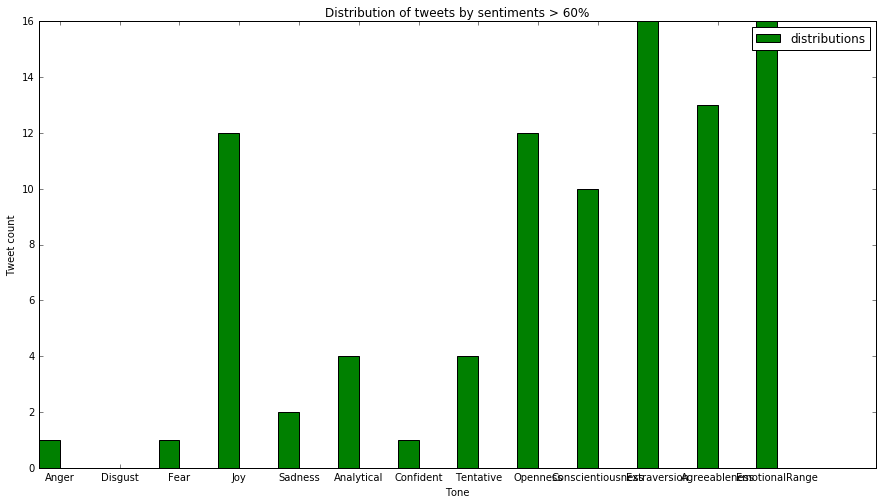

In [7]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

ind=np.arange(13)
width = 0.35
bar = plt.bar(ind, sentimentDistribution, width, color='g', label = "distributions")

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2.5, plSize[1]*2) )
plt.ylabel('Tweet count')
plt.xlabel('Tone')
plt.title('Distribution of tweets by sentiments > 60%')
plt.xticks(ind+width, tweets.columns[-13:])
plt.legend()

plt.show()

In [8]:
from operator import add
import re
tagsRDD = tweets.flatMap( lambda t: re.split("\s", t.text))\
    .filter( lambda word: word.startswith("#") )\
    .map( lambda word : (word, 1 ))\
    .reduceByKey(add, 10).map(lambda (a,b): (b,a)).sortByKey(False).map(lambda (a,b):(b,a))
top10tags = tagsRDD.take(10)

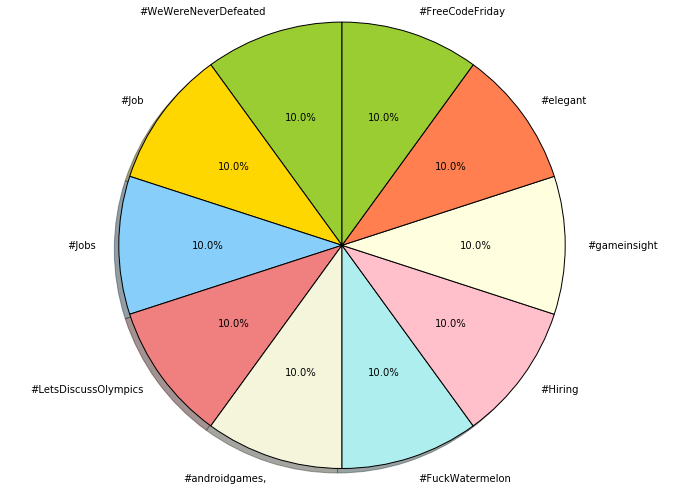

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )

labels = [i[0] for i in top10tags]
sizes = [int(i[1]) for i in top10tags]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', "beige", "paleturquoise", "pink", "lightyellow", "coral"]

plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')

plt.show()

In [10]:
cols = tweets.columns[-13:]
def expand( t ):
    ret = []
    for s in [i[0] for i in top10tags]:
        if ( s in t.text ):
            for tone in cols:
                ret += [s.replace(':','').replace('-','') + u"-" + unicode(tone) + ":" + unicode(getattr(t, tone))]
    return ret 
def makeList(l):
    return l if isinstance(l, list) else [l]

#Create RDD from tweets dataframe
tagsRDD = tweets.map(lambda t: t )

#Filter to only keep the entries that are in top10tags
tagsRDD = tagsRDD.filter( lambda t: any(s in t.text for s in [i[0] for i in top10tags] ) )

#Create a flatMap using the expand function defined above, this will be used to collect all the scores 
#for a particular tag with the following format: Tag-Tone-ToneScore
tagsRDD = tagsRDD.flatMap( expand )

#Create a map indexed by Tag-Tone keys 
tagsRDD = tagsRDD.map( lambda fullTag : (fullTag.split(":")[0], float( fullTag.split(":")[1]) ))

#Call combineByKey to format the data as follow
#Key=Tag-Tone
#Value=(count, sum_of_all_score_for_this_tone)
tagsRDD = tagsRDD.combineByKey((lambda x: (x,1)),
                  (lambda x, y: (x[0] + y, x[1] + 1)),
                  (lambda x, y: (x[0] + y[0], x[1] + y[1])))

#ReIndex the map to have the key be the Tag and value be (Tone, Average_score) tuple
#Key=Tag
#Value=(Tone, average_score)
tagsRDD = tagsRDD.map(lambda (key, ab): (key.split("-")[0], (key.split("-")[1], round(ab[0]/ab[1], 2))))

#Reduce the map on the Tag key, value becomes a list of (Tone,average_score) tuples
tagsRDD = tagsRDD.reduceByKey( lambda x, y : makeList(x) + makeList(y) )

#Sort the (Tone,average_score) tuples alphabetically by Tone
tagsRDD = tagsRDD.mapValues( lambda x : sorted(x) )

#Format the data as expected by the plotting code in the next cell. 
#map the Values to a tuple as follow: ([list of tone], [list of average score])
#e.g. #someTag:([u'Agreeableness', u'Analytical', u'Anger', u'Cheerfulness', u'Confident', u'Conscientiousness', u'Negative', u'Openness', u'Tentative'], [1.0, 0.0, 0.0, 1.0, 0.0, 0.48, 0.0, 0.02, 0.0])
tagsRDD = tagsRDD.mapValues( lambda x : ([elt[0] for elt in x],[elt[1] for elt in x])  )

#Use custom sort function to sort the entries by order of appearance in top10tags
def customCompare( key ):
    for (k,v) in top10tags:
        if k == key:
            return v
    return 0
tagsRDD = tagsRDD.sortByKey(ascending=False, numPartitions=None, keyfunc = customCompare)

#Take the mean tone scores for the top 10 tags
top10tagsMeanScores = tagsRDD.take(10)

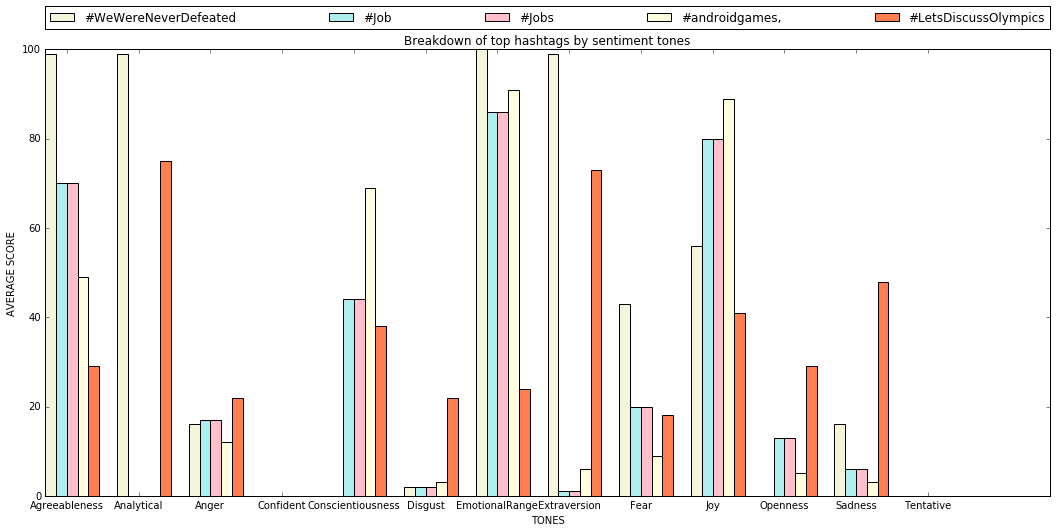

In [11]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )

top5tagsMeanScores = top10tagsMeanScores[:5]
width = 0
ind=np.arange(13)
(a,b) = top5tagsMeanScores[0]
labels=b[0]
colors = ["beige", "paleturquoise", "pink", "lightyellow", "coral", "lightgreen", "gainsboro", "aquamarine","c"]
idx=0
for key, value in top5tagsMeanScores:
    plt.bar(ind + width, value[1], 0.15, color=colors[idx], label=key)
    width += 0.15
    idx += 1
plt.xticks(ind+0.3, labels)
plt.ylabel('AVERAGE SCORE')
plt.xlabel('TONES')
plt.title('Breakdown of top hashtags by sentiment tones')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='center',ncol=5, mode="expand", borderaxespad=0.)

plt.show()